# FISSA Tutorial
Welcome to the FISSA toolbox. On this page the basic workings of FISSA will be explained step by step. For a more practical workflow example, see [Example Workflow](Example Workflow.ipynb). 

The below is merely a toy example, and should not be seen as an example of how well the toolbox works.

### Imports

In [2]:
# General imports
from __future__ import division 
import numpy as np
from PIL import Image
import glob

# Plotting toolbox (this is not needed for basic FISSA functions)
# for more info on plotting see http://ioam.github.io/holoviews/
import holoviews as hv
%load_ext holoviews.ipython

# FISSA toolbox imports
import fissa.roitools as ROI # ROI reading and adjusting tools
import fissa.readtiffs as rtp # extracing data from tiffs
import fissa.neuropil as npil # neuropil removal tools

The holoviews.ipython extension is already loaded. To reload it, use:
  %reload_ext holoviews.ipython


### Basic settings
Here we will set basic settings, like the location of the data and toolbox settings.

In [3]:
# Define tiff location
tiff_loc = '../exampleData/20150529_mini/AVG_A02.tif'

# get ROI set in zip location (ImageJ format)
ROI_loc = '../exampleData/RoiSet0529miniTrial1.zip'

# set image shape (height,width) in pixels
shpe = (176,156)

# mean image of tiff (for plotting purposes)
avg = rtp.get_mean_tiff(tiff_loc)

### Preparing Rois
In FISSA ROIs are generally used as masks. However, they're commonly defined as sets of coordinates (e.g. from the ImageJ ROI manager). We provide tools to generate masks from these.

Let's start with a list of ROI coordinates loaded from a zip of ImageJ ROIs:

In [4]:
reload(ROI)
soma_rois = ROI.readrois(ROI_loc)

soma_rois is a list of arrays, each of which gives the coordinates of one roi. E.g. the second roi:

:Overlay
   .Raster.I                :Raster   [x,y]   (z)
   .Scatter.ROI_coordinates :Scatter   [x]   (y)
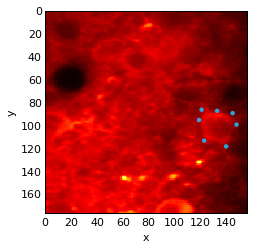

In [5]:
hv.Raster(avg)*hv.Scatter(soma_rois[1],label='ROI coordinates')

These rois needs to be changed into a mask:

In [6]:
soma_masks = ROI.getmasks(soma_rois,shpe)

/home/swl/Github/fissa/fissa/sima_borrowed/ROI.py:144: UserWarning: Polygon initialized without z-coordinate. Assigning to zeroth plane (z = 0)
  'Assigning to zeroth plane (z = 0)')


soma_masks is a list of masks, for example the second ROI:

:Layout
   .Overlay.I :Overlay
      .Raster.I  :Raster   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Raster.I  :Raster   [x,y]   (z)
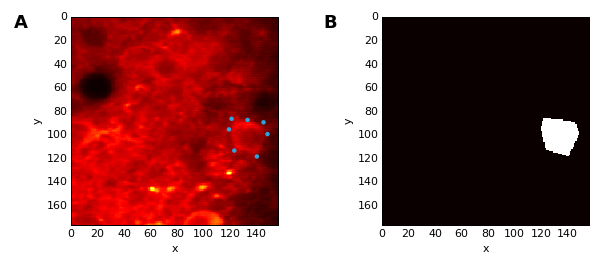

In [7]:
%%opts Raster {+axiswise}
hv.Raster(avg)*hv.Scatter(soma_rois[1])+hv.Raster(soma_masks[1])

### Defining the neuropil
Now that the ROIs are prepared in a suitable manner, we can start generating the neuropil for them. We'll do this for the second somatic ROI as well. 

In [8]:
# set neuropil settings
iterations = 15 # number of iterations/distance in pixels of neuropil. 
                # This determines the width of the neuropil. 
                # The larger this number, the larger the neuropil region surrounding a somatic ROI is.
nNpil      = 4  # number of neuropil slices
                # The larger this number, the more neuropil signals will be extracted. 
                # Make this larger if there's a lot of signals in your recordings, 
                # i.e. a lot of bunched up cells/axons/dendrites/etc.

# calculate neuropil masks
npil_masks = ROI.getmasks_npil(soma_masks[1],nNpil=nNpil,iterations=iterations)

# make a roiset with both the soma roi mask and the neuropil masks
all_masks = [soma_masks[1]]+npil_masks

# for plotting purposes it is useful to get all the mask outlines as well
outlines = []
for i in range(len(all_masks)):
    outlines += [ROI.find_roi_edge(all_masks[i])]

The first input to the getmasks_npil function should be a single mask. It then returns a list of masks for the neuropil:

:Layout
   .Overlay.I :Overlay
      .Raster.I  :Raster   [x,y]   (z)
      .Scatter.I :Scatter   [x]   (y)
   .Raster.I  :Raster   [x,y]   (z)
   .Raster.II :Raster   [x,y]   (z)
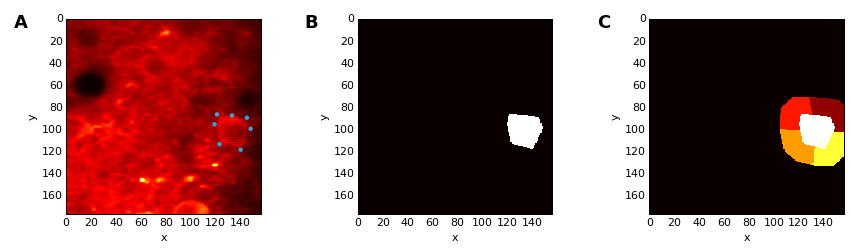

In [9]:
%%opts Raster {+axiswise}
masks_toplot = np.zeros(shpe)
masks_toplot[soma_masks[1]]=nNpil+1
for i in range(nNpil):
    masks_toplot[npil_masks[i]]=nNpil-i
hv.Raster(avg)*hv.Scatter(soma_rois[1])+hv.Raster(soma_masks[1])+hv.Raster(masks_toplot)

The neuropil masks are 'grown' from the somatic mask, by moving the mask back and forth and filling in the surrounding pixels with each movement. See the help in the get_npil_mask function for more details. The neuropil is then split up into nNpil slices of equal area. 

Note that it does not matter if a soma ROI is at the edge of an image, the neuropil will still be generated as normal and split into equal area slices. 

Note that for ring ROIs currently the center of the ROI is also included in the neuropil. To exclude the inner part of a ring ROI is still a TODO. 

In [10]:
help(ROI.get_npil_mask)

Help on function get_npil_mask in module fissa.roitools:

get_npil_mask(mask, iterations=15)
    Given the masks for cell rois, find the surround neuropil as follows: 
        for all iterations
            move original roi either
                - move polygon around one pixel in each 4 cardinal directions
                - move polygon around one pixel in each 4 diagonal directions
            Fill in all overlapped pixels
    This will generate a neuropil close the the roi shape (more square, the bigger the neuropil)
    
    Parameters
    ------------------------
    mask : array
        the reference mask to expand the neuropil from
    iterations : int
        number of iterations for neuropil
    
    Returns
    -------------------------
    A dictionary with a boolean 2d array containing the neuropil mask for each iteration



### Organize calcium traces
Next, we extract and organize the calcium traces. We usually extract these straight from the tiffs, but it is also possible to do this from arrays. 

From a tiff:

In [11]:
# load tiff stack as a Pillow object
img = Image.open(tiff_loc)

# extract the traces for each mask
S = rtp.extract_traces(img,all_masks)

From an array:

(assumed to be a 3d array of form [height,width,frame])

In [12]:
# load data (in this case from the tiff)
data = rtp.tiff2array(tiff_loc)

# predefine S
S = np.zeros((1+nNpil,data.shape[2]))

# extract traces for each masks (somatic and neuropil)
for i in range(1+nNpil):
    S[i,:]=np.mean(data[all_masks[i]],axis=0)


The advantage of extracting from a tiff rather than a full array, is that the memory load is a lot lower as only a single frame at a time is loaded into memory.

S has to be a 2-D array, with the signal and frame being referenced as: S[signal,frame]. So S[0,:] would give you the first signal. And S[2,40] would give you the 41st frame of the 3rd signal. (Just a note, Python counts from 0)

The first signal is always assumed to be from the somatic ROI, the others from neuropil ROIs.

This is also the format data needs to be in to be used by the signal separation functions. 

Let's first have a look at these signals:

:Layout
   .Overlay.I  :Overlay
      .Scatter.I   :Scatter   [x]   (y)
      .Scatter.II  :Scatter   [x]   (y)
      .Scatter.III :Scatter   [x]   (y)
      .Scatter.IV  :Scatter   [x]   (y)
      .Scatter.V   :Scatter   [x]   (y)
   .Overlay.II :Overlay
      .Curve.I   :Curve   [Frames]   (Signal)
      .Curve.II  :Curve   [Frames]   (Signal)
      .Curve.III :Curve   [Frames]   (Signal)
      .Curve.IV  :Curve   [Frames]   (Signal)
      .Curve.V   :Curve   [Frames]   (Signal)
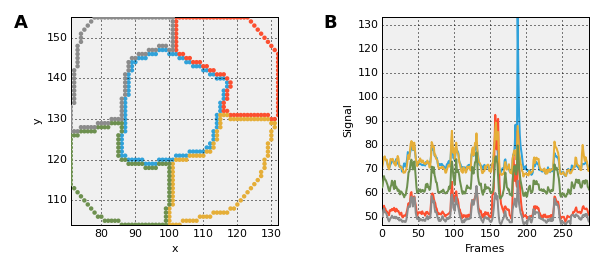

In [13]:
%%opts Curve {+axiswise}
# show the rois + extracted curves for a single tiff + cell
hv.Curve.kdims =   [hv.Dimension('Frames')]
hv.Curve.vdims = [hv.Dimension('Signal')]

fig_roi  = hv.Overlay()
fig_raw  = hv.Overlay()
for signal in range(1+nNpil):
    fig_roi *= hv.Scatter(outlines[signal])
    fig_raw *= hv.Curve(S[signal,:])

fig_roi + fig_raw

(A) The Somatic and Neuropil mask outlines. (B) The mean signal from each of the masks plotted in A, colored appropriately. 

Note how there is a lot of overlap in signals, but also distinct events. We will now separate these signals using ica/nmf. 

### Signal Separation
Finally we get the the crux of the matter, which is how to separate the signals

In [14]:
sep_method = 'ica' # Which source separation to use, 'ica', 'nmf' or 'nmf_sklearn'. 
n = 5 # how many components to estimate. If None, use PCA to estimate by finding
         # how many components would explain at least 95% of the variance

# do separation
S_sep,S_matched,A_sep,convergence = npil.separate(S,sep_method=sep_method,n=n)
    

needed 12 iterations to converge


In the above S_sep gives the basic separated signals, S_matched gives the signals as matched to the raw somatic ROI signal, A_sep gives the mixing matrix (A_sep*S_sep -> S again), and convergence gives convergence info. 

Note that even when the nmf/ica algorithms do not converge, the result tends to be good. 

Finally, how does this all look? Let's compare. 

:Layout
   .Overlay.I   :Overlay
      .Scatter.I   :Scatter   [x]   (y)
      .Scatter.II  :Scatter   [x]   (y)
      .Scatter.III :Scatter   [x]   (y)
      .Scatter.IV  :Scatter   [x]   (y)
      .Scatter.V   :Scatter   [x]   (y)
   .Overlay.II  :Overlay
      .Curve.I   :Curve   [Frames]   (Signal)
      .Curve.II  :Curve   [Frames]   (Signal)
      .Curve.III :Curve   [Frames]   (Signal)
      .Curve.IV  :Curve   [Frames]   (Signal)
      .Curve.V   :Curve   [Frames]   (Signal)
   .Overlay.III :Overlay
      .Curve.I   :Curve   [Frames]   (Signal)
      .Curve.II  :Curve   [Frames]   (Signal)
      .Curve.III :Curve   [Frames]   (Signal)
      .Curve.IV  :Curve   [Frames]   (Signal)
      .Curve.V   :Curve   [Frames]   (Signal)
   .Overlay.IV  :Overlay
      .Curve.Rank_equals_1 :Curve   [Frames]   (Signal)
      .Curve.Rank_equals_2 :Curve   [Frames]   (Signal)
      .Curve.Rank_equals_3 :Curve   [Frames]   (Signal)
      .Curve.Rank_equals_4 :Curve   [Frames]   (Signal)
      .Curve.Rank_equals_5 :Curve   [Frames]   (Signal)
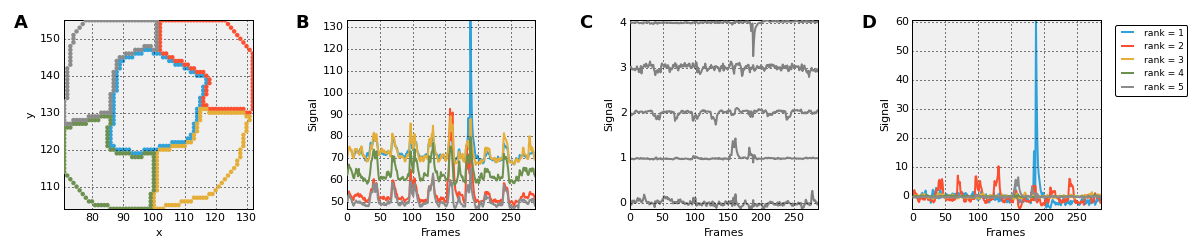

In [15]:
%%opts Curve {+axiswise} Overlay [legend_position='right']
# show the rois + extracted curves for a single tiff + cell
hv.Curve.kdims =   [hv.Dimension('Frames')]
hv.Curve.vdims = [hv.Dimension('Signal')]

fig_sep = hv.Overlay()
fig_matched = hv.Overlay()
for signal in range(len(S_matched[:,0])):
    fig_sep *= hv.Curve(S_sep[signal,:]+signal)(style={'color':'gray'})
    fig_matched *= hv.Curve(S_matched[signal,:],label='rank = '+str(signal+1))

fig_roi + fig_raw + fig_sep+fig_matched

(A) The Somatic and Neuropil mask outlines. (B) The mean signal from each of the masks plotted in A, colored appropriately.(C) Raw separated signals, before trying to estimate which one is the real somatic signal. Offsets are artificial for clarity. Note that raw ica signals can be positive or negative, but are usually flipped right way up when multiplied with their relevant component. (D) Colors do NOT correspond to A and B here. Matched signals, in order of rank of how likely they are the underlying somatic signal.

Ranking is done as follows. Imagine 3 input and 3 output signals, then we have a mixing matrix of:

[a11 a12 a13]

[a21 a22 a23]

[a31 a32 a33]

Each row represents how strongly each separated signal (as estimated by ica or nmf) is represented in the relevant raw ROI signal. Across each column then you can tell how strongly each separated signal is represented across the different ROIs (neuropils and somatic). 

Our assumption is that the cell signal is strongest in the somatic ROI, compared to the neuropil ROIs. It's signal is localized. Any other signals are either spread out over several regions (such as an overlapping dendrite/axon), or localized to other regions (other somas, etc.). 

If we normalize each column such that sum(column)=1, resulting in:

[b11 b12 b13]

[b21 b22 b23]

[b31 b32 b33]

where b11 = a11/(a11+121+131), and so on. 

The b values will be a measure of how strong each separated signal is localized in the corresponding ROI. I.e. if b11 = 1, then the column's separated signal is only present in this row's ROI. if b11 and b21 and b31 are all around 0.33, then it's a completely divided signal. 

The values b11,b12,b13 thus give a measure how localized each separated signal is to the somatic ROI (Assuming the top row is for the somatic ROI). The signals in D above then are the signals in C, multiplied by the relevant a11,a12,etc, and ordered by the size of b11,b12,etc. 

Finally, as a comparison, simply subtracting the mean neuropil signal would look as follows, with weird 'negative' events due to the large event in the red neuropil region:

:Curve   [Frames]   (Signal)
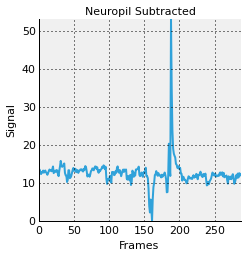

In [16]:
hv.Curve(S[0,:]-np.mean(S[1:,:],axis=0),label='Neuropil Subtracted')

### A note on baselines
With the ICA method it is not possible to estimate the somatic baseline signal, since ica signals always have mean 0. We usually take the raw signal's baseline instead. 

NMF estimates a baseline for each signal it finds. This often sets the somatic signal baseline close to zero, and finds a general background signal with a higher baseline (as above).  
